In [3]:
import pandas as pd
import numpy as np
import spacy
import nltk
from nltk.corpus import stopwords

In [4]:
df = pd.read_csv('IMDB Dataset.csv')

In [ ]:
df.head()

In [ ]:
labels = {'positive': 1, 'negative': 0}

df['sentiment'] = df['sentiment'].map(labels)
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [ ]:
## Let's preprocess our data
NLP = spacy.load('en_core_web_sm')

def preprocess(text: str) -> str:
    """Preprocess by tokenizing text and remove stopwords"""
    # stopwords 
    stop_words = set(stopwords.words('english'))
    
    # tokenize the text with spacy
    doc = NLP(text)
    
    tokens = [token.lemma_.lower() for token in doc if token.is_alpha and token.lemma_ not in stop_words]
    return " ".join(tokens)
    

In [ ]:
#let's work with a subset until I have models that I am happy with
nltk.download('stopwords')
df_a = df[:5000].copy()
df_a['review'] = df_a['review'].apply(preprocess)
df_a.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,review,sentiment
0,one reviewer mention watch oz episode hook rig...,1
1,wonderful little production br film technique ...,1
2,i think wonderful way spend time hot summer we...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,1


## Testing two models

### Using count TF-IDF

In [ ]:
## Let's convert our text to vectors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#instantiate
tfidf_vectorizer = TfidfVectorizer()

#create our X and Y
X = tfidf_vectorizer.fit_transform(df_a['review']).toarray()

y = df_a['sentiment'].values

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 42)
#TTS use random state for reproducability

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression() #instantiate a logistic regression

In [ ]:
lr.fit(X_train, y_train) #train it

LogisticRegression()

In [ ]:
preds = lr.predict(X_val) #make predictions on our validation

In [ ]:
score = lr.score(X_val, y_val) #get the score

In [ ]:
score

0.865

### Using Count Vectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vectorizer = CountVectorizer() #instantiate
X2 = vectorizer.fit_transform(df_a['review']) #create another X 

In [ ]:
X2 = X2.toarray()
#y is still the same, no need to recalculate

In [ ]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(X2, y, test_size=0.2, random_state=42)#tts

In [ ]:
lr2 = LogisticRegression() 

In [ ]:
lr2.fit(X_train2, y_train2) #fit our 2nd model

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
preds2 = lr2.predict(X_val2) #predict

In [ ]:
score = lr2.score(X_val2, y_val2) #get score

In [ ]:
score

0.851

### Evaluation

In [ ]:
from sklearn.metrics import classification_report
#make classification reports
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87       530
           1       0.83      0.89      0.86       470

    accuracy                           0.86      1000
   macro avg       0.87      0.87      0.86      1000
weighted avg       0.87      0.86      0.87      1000



In [ ]:
print(classification_report(y_val2, preds2))

              precision    recall  f1-score   support

           0       0.88      0.83      0.86       530
           1       0.82      0.87      0.85       470

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000



<Axes: >

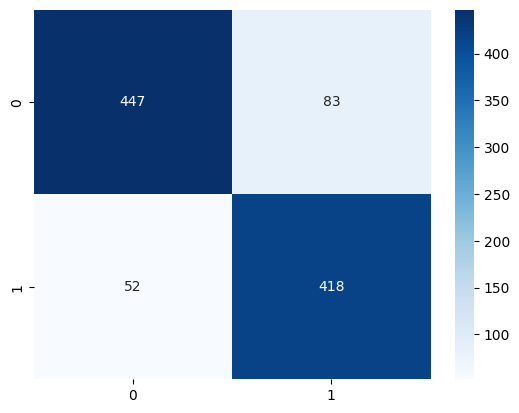

In [ ]:
#plot the confusion matrix and put it in a heat map
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cfm = confusion_matrix(y_val, preds)
sns.heatmap(cfm, annot=True, fmt='d', cmap='Blues')


<Axes: >

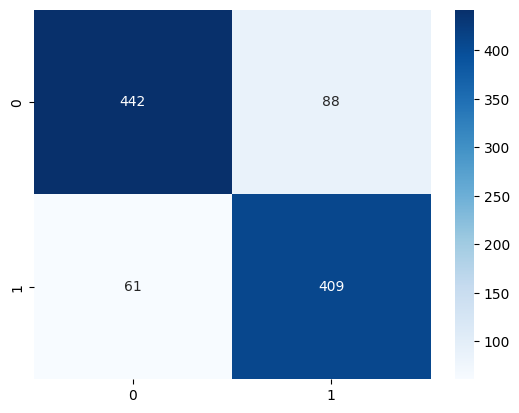

In [ ]:
cfm2 = confusion_matrix(y_val2, preds2)
sns.heatmap(cfm2, annot=True, fmt='d', cmap='Blues')


### Comparison

The first model is technically better, but not by much. In our test set, the TF-IDF correctly classified 5 more of the class one and 9 more of the class 0. This overall isn't a huge difference as there are 1000 examples in the test set, and there is a 14 prediction difference between the two. This makes the overall score of the TF-IDF higher by about 1.5% 

### explain the performance

The performance of these logistic regression models are based on the threshold of 0.5 relative to a sigmoid curve fit to the model. Both models do a better job at predicting class 0 which is negative sentiment. The model did however have a high amount of false negatives.That is we mostly missed class ones and incorrect classified it as class 0. I think changing the threshold to be slightly lower may help, but also may be a slight over fit. I would have to run K-folds to see if this trend holds true before I am confident in changing the threshold. 

### explain the limitations of the logistic regression model

The logistic regression model doesn't take the context of each word into consideration. The logistic regression just looks at each word independently. This is an issue as context can say a lot about the sentiment of a movie remove. A limitation with this specific model is that we were not able to load in the entire dataset due to limitations of RAM.